# NJ COVID-19 Case Analysis

An analysis on the number of coronivirus cases per municipality in New Jersey.

This utilizes the historical NJ Covid-19 case data from March 25, 2020 - Present collected into [this repository](https://github.com/saaqebs/covid19-newjersey). Another dataset about basic statistical information of NJ municipalities which was scraped from a [Wikipedia Article](https://en.wikipedia.org/wiki/List_of_municipalities_in_New_Jersey) that is stored in a file named `municipal.csv`.

In [1]:
from urllib import request, response, error
from matplotlib import pyplot as plt
from collections import Counter
import pandas as pd
import numpy as np

In [2]:
from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr
from scipy.optimize import curve_fit

Functions for grabbing the data from their respective sources into a a `pandas` dataframe or dictionary.

In [3]:
def get_historical_covid_data():
    url = 'https://raw.githubusercontent.com/saaqebs/covid19-newjersey/master/nj_total.csv'
    df_historical = pd.read_csv(url)
    date_nicer = lambda x: x.replace('-2020','').replace('-',' ').capitalize()
    county_nicer = lambda x: x.replace(' county','')
    df_historical['Date'] = df_historical['Date'].map(date_nicer)
    df_historical['County'] = df_historical['County'].map(county_nicer)
    df_historical = df_historical.set_index('Date')
    return df_historical

In [4]:
def get_municipal_data():
    df_municipal = pd.read_csv('data/municipal.csv')
    df_municipal['Type'] = df_municipal['Type'].map(lambda x: 'township' if x == 'township[8]' else x)
    return df_municipal.set_index('Municipal')

Using the functions to get the data.

In [5]:
df_historical = get_historical_covid_data()
df_municipal = get_municipal_data()

A brief overview of what the data looks like.

In [6]:
# Latest 5 days recorded COVID-19 data in New Jersey
df_historical.tail()

,Municipal,County,Cases
Date,,,
May 21,phillipsburg,warren,118
May 21,pohatcong township,warren,20
May 21,washington,warren,50
May 21,washington township,warren,39
May 21,white township,warren,51


In [7]:
df_municipal.head()

,County,Population,Type
Municipal,,,
newark,essex,285154,city
jersey city,hudson,270753,city
paterson,passaic,148678,city
elizabeth,union,130215,city
edison,middlesex,102450,township


## Data Visualization

Functions that print out the historical data information regarding the growth in COVID-19 cases in the specified municipalities.

A function `abline` to plot a line based on the `slope` and `intercept`.

In [8]:
def abline(slope, intercept, c='red'):
    """
    Plot a line from slope and intercept
    STACKOVERFLOW: https://stackoverflow.com/questions/7941226/how-to-add-line-based-on-slope-and-intercept-in-matplotlib
    """
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', c=c, label='Linear Fit')

A function `graph_for_municipality` that plots the historical graph of the number cases as well as a linear and polynomial fit for a given `municipal` in a particular `county`.

In [9]:
def graph_for_municipality(municipal, county, poly=2, show_linear=False, show_poly=True, max_x=50):
    county_df = df_historical[df_historical['County']==county.lower()]
    data_df = county_df[county_df['Municipal']==municipal.lower()]
    
    # 7 Week prediction
    max_x = max(max_x,len(data_df.index)) + 7
    
    model_line = pd.DataFrame({"y": data_df['Cases'], "x": list(range(len(data_df)))})
    model = LinearRegression().fit(model_line[['x']],model_line['y'])
    slope = model.coef_[0]
    intercept = model.intercept_
    
    # Polynomial fit code: https://towardsdatascience.com/modeling-functions-78704936477a
    coef = np.polyfit(model_line['x'], model_line['y'], poly)
    equ = np.poly1d(coef)
    x_plot = np.arange(0,max_x,4)
    y_plot = equ(x_plot)
    
    plt.figure(figsize=(10, 5))
    plt.xticks(np.arange(2,max_x,10))
    plt.grid(b=True, color='black',alpha=0.5,linestyle='dashed', linewidth=0.5)
    
    if show_linear:
        abline(slope,intercept, c='#b19cd9')
    
    if show_poly:
        plt.plot(x_plot, y_plot, color='m',linewidth=0.7, label='Polynomial Fit')
        
    if show_poly or show_linear:
        plt.plot(data_df.index.values, data_df['Cases'], '.', linewidth=3, c='black', label='Covid 19 Cases')
    else:
        plt.plot(data_df.index.values, data_df['Cases'], linewidth=3, c='black', label='Covid 19 Cases')
    
    plt.xlabel('Date')
    plt.ylabel('Number of Cases')
    plt.title('Tracking COVID-19 Cases in {}, {} County'.format(municipal,county))
    
    plt.legend()
    plt.show()
    
    print("Linear model slope: {:.4f}".format(slope))
    print("Spearmen R: {:.4f}".format(spearmanr(model_line['x'], model_line['y']).correlation))

A function `graph_from_municipalities` that plots the historical graph from a list of `municipals`.

In [10]:
def graph_from_municipalities(municipals):
    lines = []
    data = []
    longest = 0
    plt.figure(figsize=(10, 5))
    
    for municipal, county in municipals:
        county_df = df_historical[df_historical['County']==county.lower()]
        curr_data = county_df[county_df['Municipal']==municipal.lower()]
        curr_case = np.array(curr_data['Cases'],dtype='int32')
        curr_dates = curr_data.index.values
        line, = plt.plot(curr_dates,curr_case,linewidth=3,label=municipal)
        
        longest = max(longest,len(curr_data))
        data.append(curr_data)
        lines.append(line)
    
    plt.legend(handles=lines, loc='upper left')
    plt.xticks(np.arange(2,longest,10))
    plt.grid(b=True, color='black',alpha=0.5,linestyle='dashed', linewidth=0.5)
    plt.xlabel('Date')
    plt.ylabel('Number of Cases')
    plt.title('Trackling COVID-19 Cases in New Jersey')
    plt.show()

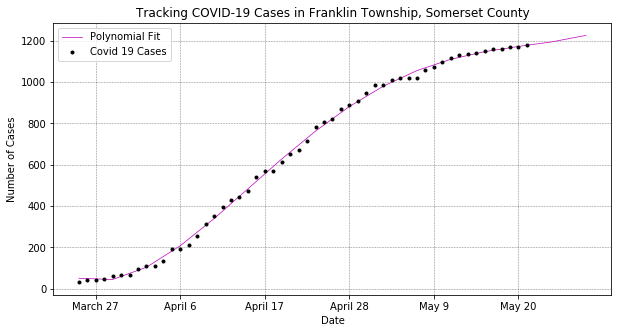

Linear model slope: 25.8709
Spearmen R: 0.9998


In [11]:
graph_for_municipality('Franklin Township','Somerset',4)

Example graphs for the following townships: New Brunswick, Old Bridge Township, Hamilton, Princeton.

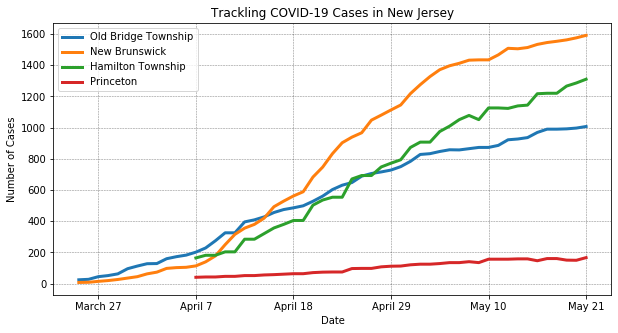

In [12]:
central = [('Old Bridge Township', 'middlesex'),
           ('New Brunswick', 'middlesex'),
           ('Hamilton Township', 'mercer'),
           ('Princeton', 'mercer')]

graph_from_municipalities(central)

## Analysis

Firstly, we must combine `df_historical` and `df_municipal` into one complete dataframe called `covid_df`.

In [13]:
todays_date = 'May 21'
todays_df = df_historical.loc[todays_date]

In [14]:
def combine_dataframes(date, df_historical=df_historical, df_municipal=df_municipal):
    important_columns = ["Municipal","County","Cases"]
    todays_df = df_historical.loc[date]
    covid_df = pd.merge(df_municipal, todays_df[important_columns], on=important_columns[:2], how="left")
    covid_df['Cases'] = covid_df['Cases'].map(lambda i: 0 if np.isnan(i) else int(i))
    covid_df = covid_df.set_index('Municipal')
    covid_df['Case Rates'] = covid_df['Cases'] / covid_df['Population']
    return covid_df

Some basic statistics for the entire `dataframe`.

In [15]:
covid_df = combine_dataframes('May 21')
covid_df.head()

print('Mean for Case Rate: {}'.format(np.mean(covid_df['Case Rates'])))
print('\nMedian for Cases: {}'.format(np.median(covid_df['Cases'])))
print('Variance for Cases: {}'.format(np.var(covid_df['Cases'])))

Mean for Case Rate: 0.01219279070319479

Median for Cases: 76.0
Variance for Cases: 412056.79169864615


In [16]:
covid_df.describe()

,Population,Cases,Case Rates
count,565.000000,565.000000,565.000000
mean,15939.192920,259.752212,0.012193
std,24560.478151,642.485322,0.015077
min,5.000000,0.000000,0.000000
25%,3593.000000,23.000000,0.005379
50%,8312.000000,76.000000,0.009123
75%,18651.000000,228.000000,0.014960
max,285154.000000,6892.000000,0.271536


A basic histogram for a new column `Case Rates`.

In [17]:
def histogram_case_rates(covid_df=covid_df):
    covid_no_outliers = covid_df[covid_df['Case Rates'] < 0.10]
    plt.hist(covid_no_outliers['Case Rates'],bins=20)
    plt.xlabel('Case to Population Ratio')
    plt.ylabel('Number of Counties')
    plt.title('Case Rates')
    plt.show()

In [18]:
covid_df[covid_df['Case Rates'] > 0.10]     # outliers

,County,Population,Type,Cases,Case Rates
Municipal,,,,,
woodland township,burlington,1775,township,240,0.135211
rockleigh,bergen,534,borough,145,0.271536


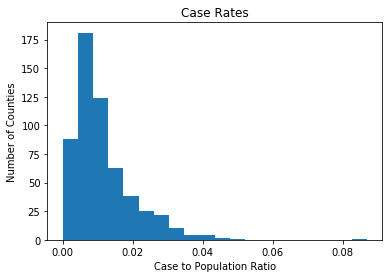

In [19]:
histogram_case_rates()

A function `scatterplot_features` that plots and a linear regression and give some correlation coefficients based on the input features.

In [20]:
def scatterplot_features(X, Y, title='Scatterplot of {} and {}',df=covid_df):
    plt.scatter(df[X],df[Y],c='orange')
    plt.grid(b=True, color='grey',alpha=0.5,linestyle='dashed', linewidth=0.5)
    if title == 'Scatterplot of {} and {}':
        plt.title(title.format(X,Y))
    else:
        plt.title(title)
    plt.xlabel(X)
    plt.ylabel(Y)
    model = LinearRegression().fit(df[[X]], df[Y])
    abline(model.coef_[0],model.intercept_)
    plt.show()
    print("Linear model slope: {}".format(model.coef_[0]))
    print("Spearmen R: {}".format(spearmanr(df[X], df[Y]).correlation))

Graphing the variable relationships for each unique type of township.

In [21]:
def graphing_per_municipality_type():
    for m_type in set(df_municipal['Type']):
        scatterplot_features('Population',
                             'Case Rates',
                             title=m_type.capitalize(), 
                             df=covid_df[covid_df['Type']==m_type])

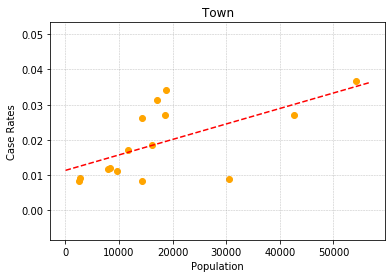

Linear model slope: 4.396628447969818e-07
Spearmen R: 0.6392857142857141


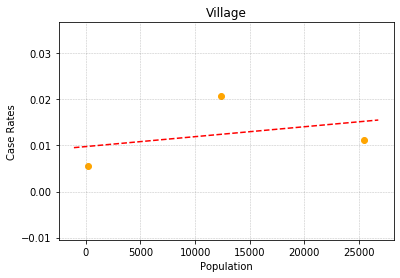

Linear model slope: 2.1527050042719681e-07
Spearmen R: 0.5


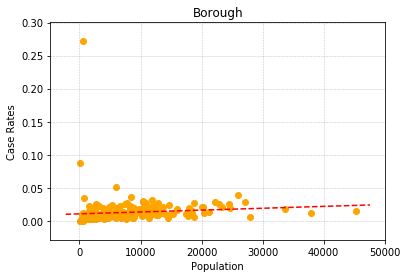

Linear model slope: 2.8243582993605494e-07
Spearmen R: 0.5137758318256301


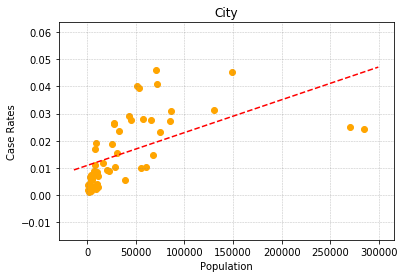

Linear model slope: 1.2090500452336064e-07
Spearmen R: 0.8073934944079227


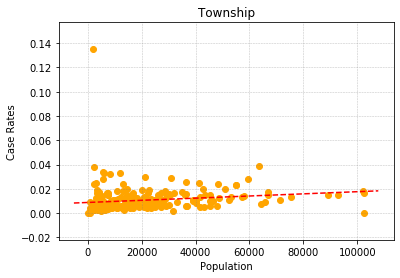

Linear model slope: 8.872152666008541e-08
Spearmen R: 0.4631893760479378


In [22]:
graphing_per_municipality_type()

Removing the outliers from the dataset when comparing the populations and case rates.

In [23]:
def removing_outliers(m_type,conditional):
    type_df = covid_df[conditional]
    scatterplot_features('Population','Case Rates',title=m_type.capitalize(), df=type_df[type_df['Type'] == m_type])

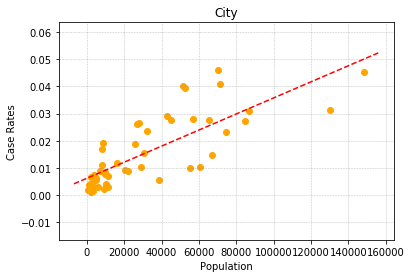

Linear model slope: 2.9581224639376666e-07
Spearmen R: 0.8124369747899159


In [24]:
removing_outliers('city',covid_df['Population'] < 200000)

In [25]:
type_map = {'village': 0, 'borough': 1, 'town': 2, 'township': 3, 'city': 4}
covid_df['Type'] = covid_df['Type'].map(type_map)
covid_df.head()

,County,Population,Type,Cases,Case Rates
Municipal,,,,,
newark,essex,285154,4,6892,0.024169
jersey city,hudson,270753,4,6777,0.025030
paterson,passaic,148678,4,6717,0.045178
elizabeth,union,130215,4,4066,0.031225
edison,middlesex,102450,3,1679,0.016388


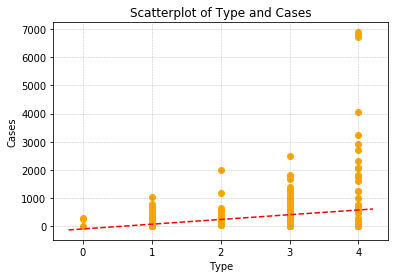

Linear model slope: 168.51035916824202
Spearmen R: 0.25611802847576326


In [26]:
scatterplot_features('Type','Cases')